In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import seaflowpy as sfp
import mpld3 

from matplotlib import path
import matplotlib.patches as patches

import glob
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_filter_line(inst, bead_coords):
    # this is using fsc and D2
    # slopes to use for calibration
    calib = pd.DataFrame()

    calib['inst'] = [740, 740, 751, 751, 989, 989]
    calib['regime'] = ['coastal', 'oligo', 'coastal', 'oligo', 'coastal', 'oligo']
    calib['slope_S'] = [0.62, 0.89, 0.63, 0.62, 0.87, 0.91]
    calib['slope_B'] = [2.17, 1.95, 2.3, 2.59, 1.64, 1.75]
    
    m_S = np.mean(calib.slope_S[(calib['inst']==inst)])
    m_B = np.mean(calib.slope_B[(calib['inst']==inst)])

    bead_x = bead_coords[0]
    bead_y = bead_coords[1]*2
    
    max_x = 64000.
    
    intercept_S = bead_y - m_S*bead_x
    c_B = bead_y - m_B*bead_x
    intercept_B = m_B*max_x + c_B
    
    # create an array with the coordinates for each point in the polygon
    filter_polygon = [(0, 0), (0, intercept_S), (bead_x, bead_y), (max_x,intercept_B), (max_x, 0), (0,0)]

    return filter_polygon

def filter_evt(filter_polygon, data):
    # http://stackoverflow.com/questions/31542843/inpolygon-for-python-examples-of-matplotlib-path-path-contains-points-method
    # define the path using the points from get_filter_line
    
    p = path.Path(filter_polygon)
    evt = np.reshape([data[0].df['fsc_small'], data[0].df['D2']], (len(data[0].df), 2))
    opp = np.where(p.contains_points(evt))
    
    return opp
    

In [3]:
# bead coordinates
bead_coords = pd.DataFrame()

bead_coords['inst'] = [740, 740, 751, 751, 989, 989]
bead_coords['regime'] = ['oligo', 'coastal', 'oligo', 'coastal', 'oligo', 'coastal']
bead_coords['fsc_small'] = [49000, 38100, 53500, 41400, 50800, 40700]
bead_coords['D2'] = [24400, 23200, 23500, 22400, 20500, 19000]

# load in the data, one file at a time per instrument
# set the wdirectory where the data is stored

datadir = "/Volumes/ceg/Sophie/bead_calibration/"

# select instrument
inst = 751
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'coastal' # or oligo
regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

# get the coordinates for the filter polygon for this instrument and bead combination

bead_xy = np.empty(2)

bead_xy[0] = bead_coords.fsc_small[(bead_coords['inst']==inst) & (bead_coords['regime']==regime)]
bead_xy[1] = bead_coords.D2[(bead_coords['inst']==inst) & (bead_coords['regime']==regime)]

filter_polygon = get_filter_line(inst, bead_xy)

print filter_polygon

#bead_data.df['fsc_small'], bead_data.df['D2']

[(0, 0), (0, 13562.5), (53500.0, 47000.0), (64000.0, 72672.500000000015), (64000.0, 0), (0, 0)]


/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.18um.evt


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


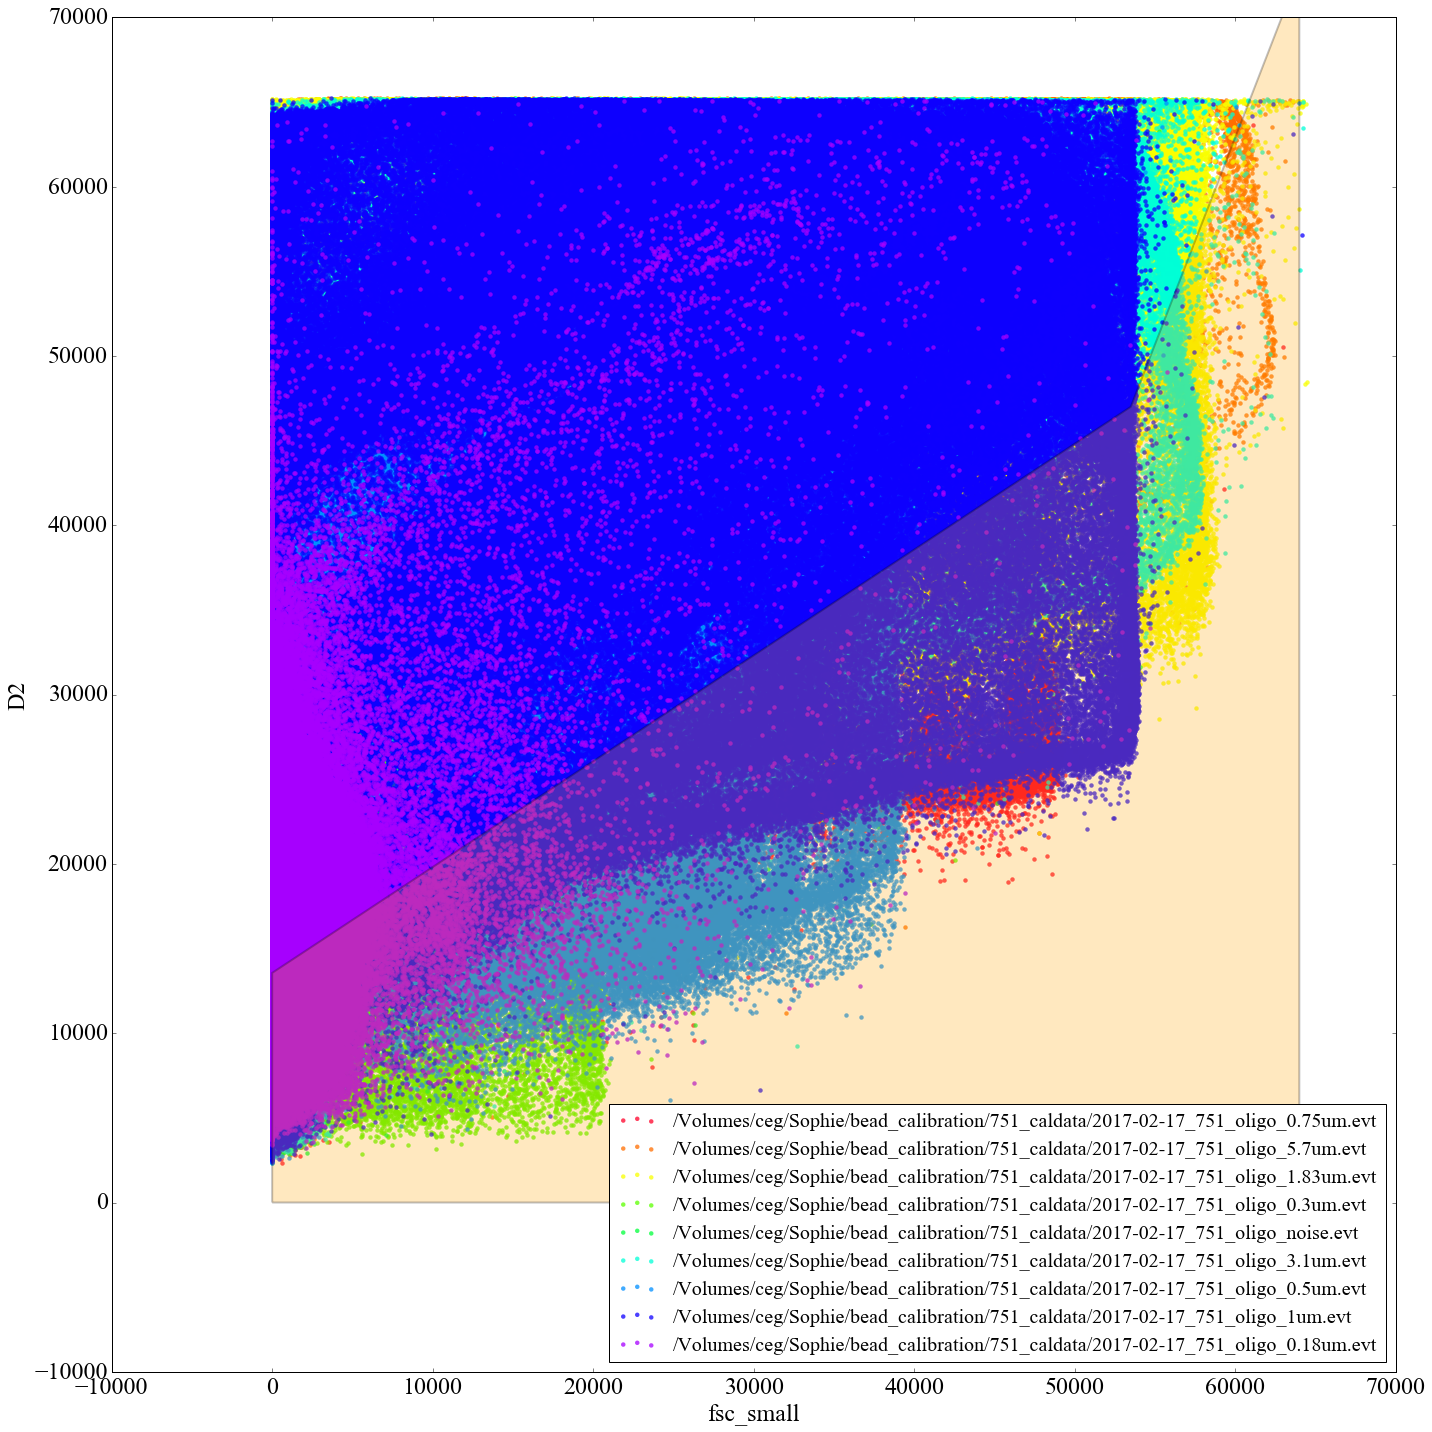

In [4]:
fig1 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

ax = fig1.add_subplot(111)

cc = 0
for f in files:
    print f
    bead_data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    plt.scatter(bead_data.df['fsc_small'], bead_data.df['D2'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f, alpha = 0.75)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D2', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

p = path.Path(filter_polygon)

patch = patches.PathPatch(p, facecolor='orange', lw=2, alpha = 0.25)
ax.add_patch(patch)

plt.axis([-10000, 70000, -10000, 70000])
plt.show()


In [9]:
bead_data = []

for f in files:
    print f
    bead_data.append(sfp.EVT(f, transform=False, columns=["fsc_small", "D2"]))
    
opp = filter_evt(filter_polygon, bead_data)

print len(opp[0])/np.float(len(bead_data[0].df))*100

/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.18um.evt
41.5899216995


In [8]:
print len(opp[0])

402830


In [7]:
print opp


(array([     1,      2,      6, ..., 968572, 968573, 968575]),)
